In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import numpy as np
import pymc as pm
from pytensor import *
import pytensor.tensor as at
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def cut_data(Data, time):
    max_locator = np.argmax(Data)
    dtime = time[2] - time[1]
    pre_zero_time = np.linspace(max_locator, 1+dtime, max_locator)
    pre_zero_time = pre_zero_time * dtime * -1
    #time2 = np.append(pre_zero_time, time)
    
    time = time[:-max_locator] 
    Data = Data[max_locator:]
    #Data = np.append(Data, pre_zero_time * 0)

    return Data, time



def remove_bckg(Data):
    # To remove the background the highest value before the pulse is substracted
    
    max_locator = np.argmax(Data)
    
    Data_mask = np.array(Data[1:max_locator - 3])
    Bckg = np.max(Data_mask)
    Data_bckg = Data #- Bckg
    
    return Data_bckg



def unpack_Data(FileName):
    """ Unpack Data File"""

    ## First the data is imported, the background removed, the maximum shifted to t=0 and everything is normalized to Exc_Density

    rows_to_skip = 73
    time1 = None
    while time1 is None:
        try:
            time1, Data1 = np.loadtxt(FileName, unpack=True, skiprows= rows_to_skip, encoding='unicode_escape')
        except:
            rows_to_skip += 1
            pass
        else:
            time1, Data1 = np.loadtxt(FileName, unpack=True, skiprows = rows_to_skip, encoding='unicode_escape')
            
    Data1 = np.array(Data1)
    len_Data = len(Data1)
    
    """ Remove Background from before Pulse"""

    Data2 = remove_bckg(Data1)

    
    """ Cut Data into Shape"""
    Data3, time2 = cut_data(Data2, time1)
    
   
    """ Normalize Data"""
    #Data3 = medfilt(Data3, 9)
    Data4 = Data3 / Data3[0]#[np.argmax(Data3)]#
    
    Data4[Data4 <= 0] = np.min(Data4[Data4 > 0])


    return time2, Data4, len_Data



def make_Dataframe(time, data_raw, len_Data):

    Data = pd.DataFrame()


    ## The data is cut to the correct lengths and stored in a pd.Dataframe
    ### each dataset starts at t = 0
    
    Data['Time'] = time[0]
    Data['0'] = data_raw[0]

    i = 1
    while i < len(len_Data):

        Data2 = data_raw[i]

        if len(Data2) != len(np.array(Data['Time'])):
            if len(Data2) > len(np.array(Data['Time'])):
                a = np.abs(len(Data2)-len(np.array(Data['Time'])))
                Data2 = Data2[0:-a]
            else:
                a = np.abs(len(Data2) - len(np.array(Data['Time'])))
                Data2 = np.append(Data2, np.zeros(a))

        Data[str(i)] = Data2

        i += 1


    return Data



def unpack_Info(args):
    names, info = np.loadtxt(args, unpack=True, skiprows=1, max_rows=24, delimiter=':', dtype=str, encoding='unicode_escape')
    sample_name = str(info[np.where(names == '  Sample ')])[2:-2]
    wavelength = float(str(info[np.where(names == '  Exc_Wavelength ')])[3:-4])  # in nm
    sync_frequency = float(str(info[np.where(names == '  Sync_Frequency ')])[3:-4])  # in Hz
    signal_rate = float(str(info[np.where(names == '  Signal_Rate ')])[3:-5])  # in cps
    pile_up = signal_rate / sync_frequency * 100  # in %

    attenuation = str(info[np.where(names == '  Exc_Attenuation ')])[3:-6]
    if attenuation == 'open':
        attenuation = 1
    else:
        attenuation = float(attenuation[0:-1]) / 100

    return pile_up, attenuation, wavelength, sync_frequency, sample_name



def Fluence_Calc(wavelength, intensity):
    """ Unpack Ref Data File"""
    wl400, wl505, wl630 = np.loadtxt(str(folder + '/TRPL_Files/2022_05_01_TRPL_Laserpower.txt'), unpack=True, skiprows=1)


    if wavelength == 397.7:

        laser_fluence = wl400[0] * intensity + wl400[1]

    elif wavelength == 505.5:

        laser_fluence = wl505[0] * intensity + wl505[1]

    elif wavelength == 633.8:

        laser_fluence = wl630[0] * intensity + wl630[1]

    return laser_fluence



def unpack_filenames(FileNames, intensity, Reflectance):
    
    pile_up = []
    sample_names = []
    data = []
    time = []
    len_Data = []
    Fluence = []
    y_list = []
    
    for FileName in FileNames:
        pile_up_1, attenuation, wavelength, frequency, sample_name_1 = unpack_Info(FileName)
        pile_up.append(pile_up_1)
        sample_names.append(sample_name_1)
            
        
        time2, Data4, len_Data1 = unpack_Data(FileName)
        data.append(Data4)
        time.append(time2)
        len_Data.append(len_Data1)
    
        
    #### Length of Data is changed so it fits into a single Dataframe
    for y in range(1,len(FileNames)):
        len_Data[y] = len_Data[y] + len_Data[y - 1]
    
    #### The Dataframe is created    
    df = make_Dataframe(time, data, len_Data) 

    return df

def multi_exp_approximation(x,y, A1, A2, A3, tau1, tau2, tau3, beta2, beta3, y0):
    
    decay = A1*np.exp(-x/tau1) + A2*np.exp(-(x/tau2)**beta2) #+ A3*np.exp(-(x/tau3)**beta3) + 10**(-y0)
    return np.sqrt(decay)

In [3]:
def X_n_maker(d_factor, size, dx, D, Sf, Sb):
    x_size = at.zeros(shape=(at.shape(size),at.shape(size)))
    Xn_1 = at.extra_ops.fill_diagonal_offset(x_size, d_factor, -1)
    
    Xn_2a = at.extra_ops.fill_diagonal_offset(x_size, 1-2.*d_factor, 0)
    Xn_2a1 = at.set_subtensor(Xn_2a[0,0],1-d_factor - (dx/D)*d_factor *Sf)
    #Xn_2a2 = at.set_subtensor(Xn_2a1[0,1], d_factor *2)
    #Xn_2a3 = at.set_subtensor(Xn_2a2[-1,-2], d_factor *2)
    Xn_2 = at.set_subtensor(Xn_2a1[-1,-1],1-d_factor - (dx/D)*d_factor *Sb)
    
    Xn_3 = at.extra_ops.fill_diagonal_offset(x_size, d_factor, 1)
    
    return Xn_1 + Xn_2 + Xn_3

In [4]:
def time_steps_loop(n_dens, ratio, ds, alpha_PL_blue, alpha_PL_red, z_array, d_factor, D):
   
    
    PL_wl_blue = at.sum(n_dens*n_dens * at.exp(-at.outer(alpha_PL_blue, z_array)))
    PL_wl_red = at.sum(n_dens*n_dens * at.exp(-at.outer(alpha_PL_red, z_array)))


    ratio_current = PL_wl_red/PL_wl_blue

    A_n = X_n_maker(-d_factor, n_dens, ds, D, 0, 0)
    B_n = X_n_maker(d_factor, n_dens, ds, D, 0, 0)



    N_new = at.dot(at.linalg.inv(A_n), B_n.dot(n_dens))
    
    N_new = at.switch(at.le(N_new, 0), 0, N_new)
    
    return N_new, ratio_current
    

In [16]:
def model_diffusion(n_dens0, d_factor, D, ds, alpha_PL_blue, alpha_PL_red, z_array, time, y_init):

    result_time, _ = pytensor.scan(fn=time_steps_loop,
                                            outputs_info=[n_dens0, ds*0],
                                            non_sequences=[ds, alpha_PL_blue, alpha_PL_red, z_array, d_factor, D], n_steps = at.shape(time))

    ratio = result_time[1]
    ratio_result = ratio - ratio[0]
    ratio_report = ratio_result*pm.HalfNormal('scaling', 1)

    return ratio_report


# Import Data

C:\Users\kober-czerny\AppData\Local\Temp\ipykernel_24544\980136631.py:102: UserWarning: Input line 5 contained no data and will not be counted towards `max_rows=24`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  names, info = np.loadtxt(args, unpack=True, skiprows=1, max_rows=24, delimiter=':', dtype=str, encoding='unicode_escape')
C:\Users\kober-czerny\AppData\Local\Temp\ipykernel_24544\980136631.py:173: RuntimeWarning: divide by zero encountered in power
  decay = A1*np.exp(-x/tau1) + A2*np.exp(-(x/tau2)**beta2) #+ A3*np.exp(-(x/tau3)**beta3) + 10**(-y0)
C:\Users\kober-czerny\AppData\Local\Temp\ipykernel_24544\980136631.py:174: Runti

(0.0, 300.0)

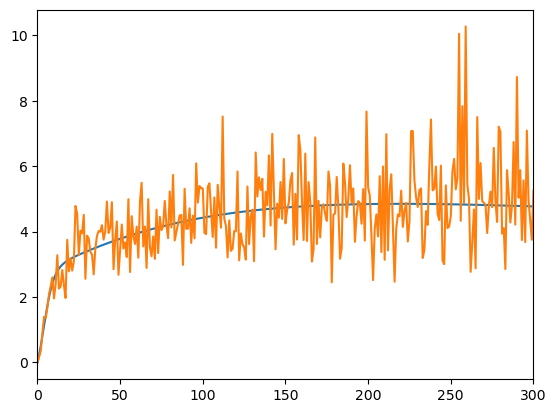

In [44]:
data_folder_spectral = r'C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\Collaborations\Amit\2D_passivations\2025_01_27_Amit_TRPL'
Sample_name = 'S5'
blue_file = r'S5_glass_757nm.dat'
red_file = r'S5_glass_857nm.dat'
limits = [0,300] #ns

blue = np.array([757])
red = np.array([857])

thickness = 800
excitation_wl = 398
##################################################


FileNames = [f'{data_folder_spectral}/{blue_file}',f'{data_folder_spectral}/{red_file}']
df = unpack_filenames(FileNames, 0, 0)

x_raw = np.array(df['Time'])[0:]
limit_marker = np.where(x_raw >= limits[1])[0][0]
x_raw = x_raw[:limit_marker-limits[0]]

yblue_raw = np.array(df['0'])[limits[0]:limit_marker]   #blue
yred_raw = np.array(df['1'])[limits[0]:limit_marker]   #red

yblue_norm = yblue_raw/yblue_raw.max()
yred_norm = yred_raw/yred_raw.max()

popt1, _ = curve_fit(multi_exp_approximation, x_raw, np.sqrt(yblue_norm), maxfev=100000)
yblue_norm_spline = multi_exp_approximation(x_raw, *popt1)**2

popt2, _ = curve_fit(multi_exp_approximation, x_raw, np.sqrt(yred_norm), maxfev=100000)
yred_norm_spline = multi_exp_approximation(x_raw, *popt2)**2


y_raw = (yred_norm_spline/yblue_norm_spline)  #*0     #red/blue
y_raw -= y_raw[0]

x = x_raw
y = yred_norm/yblue_norm
y -= y[0]

#plt.plot(x,np.abs(y))
plt.plot(x_raw, y_raw)
plt.plot(x, y)
#plt.ylim(bottom=0, top=2)
plt.xlim(left=0, right=limits[1])
#plt.yscale('log')

In [45]:
File_name = r"C:\Users\kober-czerny\Desktop\Python Scripts\alphas_lookup_table.csv"
Raw_File = pd.read_csv(File_name, sep=",")
wavelength = Raw_File["wavelength"].values
alpha2 = Raw_File["1.55"].values


blue_index = []
red_index = []


for i in np.arange(len(blue)):
    blue_index.append(np.where(np.round(wavelength,0) == blue[i])[0][0])
    red_index.append(np.where(np.round(wavelength,0) == red[i])[0][0])

wavelength_PL_blue = wavelength[blue_index]
wavelength_PL_red = wavelength[red_index]

alpha_PL_blue = alpha2[blue_index]*1e-4
alpha_PL_red = alpha2[red_index]*1e-4


z_array = np.linspace(0,thickness,20)*1e-3
ds = np.abs(z_array[1]-z_array[0])

F = 1 # if there is no recombination, F does not matter here...
alpha_exc = alpha2[np.where(np.round(wavelength, 0) == excitation_wl)[0][0]]
generation = np.exp(-alpha_exc*1e-4*z_array)
g_sum = np.sum(generation)*ds
N = F*generation/g_sum



pymc_model = pm.Model()

with pymc_model:

    mu_vert = pm.LogNormal('mu_vert', 3, 3)
    D = pm.Deterministic('Diffusion_coefficient', 2*mu_vert*(1.380649e-23*292/1.6021766e-19))*1e8

    d_factor = D*np.abs(x[1]-x[0])*1e-9/(2*ds*ds)

    ratio_calc = model_diffusion(at.as_tensor_variable(N), d_factor, D, at.as_tensor_variable(ds), at.as_tensor_variable(alpha_PL_blue), at.as_tensor_variable(alpha_PL_red), at.as_tensor_variable(z_array), at.as_tensor_variable(x*1e-9), y_raw[1])

    ratio_calc_saved = pm.Deterministic('ratio', ratio_calc)

    Y_obs = pm.Normal('Y_obs', mu=ratio_calc, sigma = 0.1, observed = y_raw)

    trace = pm.sample(step=pm.Metropolis())

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: save_mem_new_scan
ERROR (pytensor.graph.rewriting.basic): node: for{cpu,scan_fn&scan_fn}(TensorConstant{(1,) of 301}, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, Elemwise{add,no_inplace}.0, Inv.0, Elemwise{add,no_inplace}.0, Inv.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\kober-czerny\.conda\envs\pymc5_env\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1925, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kober-czerny\.conda\envs\pymc5_env\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1084, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kober-czerny\.conda\envs\pymc5_env\Lib\site-pa

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: save_mem_new_scan
ERROR (pytensor.graph.rewriting.basic): node: for{cpu,scan_fn}(TensorConstant{(1,) of 301}, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, Elemwise{add,no_inplace}.0, Inv.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\kober-czerny\.conda\envs\pymc5_env\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1925, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kober-czerny\.conda\envs\pymc5_env\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1084, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kober-czerny\.conda\envs\pymc5_env\Lib\site-packages\pytensor\scan\rewriting.py", line 1628, in save_mem_new_scan
    subtens = Subtensor(nw_slice)

1.0443517745542181


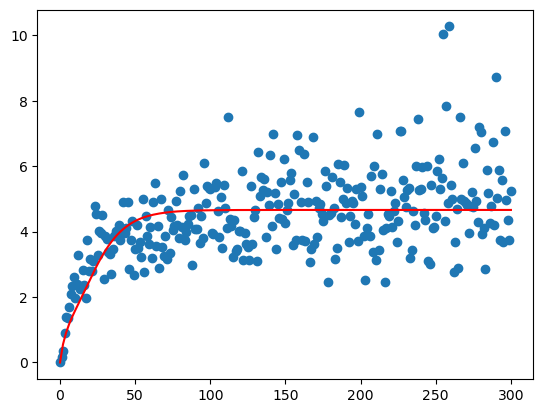

In [46]:
plt.scatter(x,y)
medline = np.median(trace.posterior.ratio,axis=(0,1)).T


plt.plot((x)[::2], medline[::2], alpha=1, c='red')
print(np.median(trace.posterior.mu_vert.values))
plt.show()

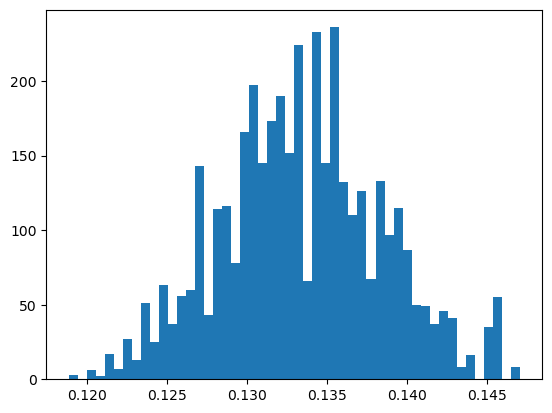

In [39]:
plt.hist(np.log10(trace.posterior.mu_vert.values.ravel()),bins=50)
plt.show()

In [43]:
ratio_median = np.median(trace.posterior.ratio,axis=(0,1))
ratio_q1 = np.quantile(trace.posterior.ratio,0.25,axis=(0,1))
ratio_q3 = np.quantile(trace.posterior.ratio,0.75,axis=(0,1))

df_ratio_save = pd.DataFrame()

df_ratio_save['time (ns)'] = x
df_ratio_save['ratio_median'] = ratio_median
df_ratio_save['ratio_q1'] = ratio_q1
df_ratio_save['ratio_q3'] = ratio_q3

df_ratio_save.to_csv(f'{data_folder_spectral}/spectral_shift/{Sample_name}_fit_to_diffusion.dat', sep='\t', index= True, mode='w')

df_mobility = pd.DataFrame()
df_mobility['mu_vert(cm2(Vs)-1)'] = trace.posterior.mu_vert.values.ravel()

df_mobility.to_csv(f'{data_folder_spectral}/spectral_shift/{Sample_name}_mobility_values.dat', sep='\t', index= True, mode='w')

In [11]:
def AnBn(ds, dx, mu, Sf, Sb, n_dens):

      D = mu*0.025
      d_factor = D*dx/(2*ds*ds)

      z_array = np.linspace(0,600,30)*1e-7
      steps = len(z_array)



      A_n = X_n_maker(-d_factor, n_dens, ds, D, 0, 0)
      B_n = X_n_maker(d_factor, n_dens, ds, D, 0, 0)

      return A_n, B_n

In [83]:
def simulate_diffusion_PL(ds, dx, mu, Sf, Sb, iter, N, P,  alpha_PL_blue, alpha_PL_red, z_array, wavelength_PL_blue, wavelength_PL_red):
    ratio = ()

    for k in np.arange(iter):

        PL_wl_blue = alpha_PL_blue*0
        PL_wl_red = alpha_PL_red*0

        for j, _ in enumerate(alpha_PL_blue):

            PL_wl_blue[j] = np.sum(N*P*np.exp(-alpha_PL_blue[j]*z_array))
            PL_wl_red[j] = np.sum(N*P*np.exp(-alpha_PL_red[j]*z_array))

            #plt.semilogy(z_array, init_n**2*np.exp(-alpha_PL[i]*z_array))
            #plt.semilogy(z_array, final_n**2*np.exp(-alpha_PL[i]*z_array))

        ratio = np.append(ratio, np.sum(PL_wl_red)/np.sum(PL_wl_blue))  

        A_n = X_n_maker(-d_factor, N, ds, D, 0, 0)
        B_n = X_n_maker(d_factor, N, ds, D, 0, 0)

        A_n, B_n = AnBn(ds, dx, mu, Sf, Sb)

        N_new = np.linalg.solve(A_n, B_n.dot(N))
        P_new = np.linalg.solve(A_n, B_n.dot(P))
       

        N = N_new
        P = P_new
        #N_new[N_new < 0] = 0
        #plt.scatter(k+1, np.sum(N_new)/ds, c='black')
        #plt.plot(np.arange(steps),N_new)
    return ratio

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import random

File_name = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\nk_0br_1.txt"
Raw_File = pd.read_csv(File_name, sep="\t")
wavelength = 1240/Raw_File["eV"].values

#File_name = r"C:\Users\kober-czerny\Downloads\refractive_index\refractive_index\pure_pb_Eg=1.55.tsv"
#Raw_File = pd.read_csv(File_name, sep="\s", names = ['eV', 'n', 'k-Bottom'])
#wavelength = Raw_File["eV"].values

k2 = Raw_File["k-Bottom"].values
alpha2 = 2*np.pi*k2/(wavelength*1e-7)

blue_index = []
red_index = []
blue = np.array([ 748, 768, 778, 788, 798, 803])
red = np.array([813, 818, 828, 838, 848, 868])

for i in np.arange(len(blue)):
    blue_index.append(np.where(np.round(wavelength,0) == blue[i])[0][0])
    red_index.append(np.where(np.round(wavelength,0) == red[i])[0][0])

print(wavelength[blue_index])
wavelength_PL_blue = wavelength[blue_index]
wavelength_PL_red = wavelength[red_index]

alpha_PL_blue = alpha2[blue_index]
alpha_PL_red = alpha2[red_index]

z_array = np.linspace(0,600,30)*1e-7
ds = np.abs(z_array[1]-z_array[0])

F = 4.8e10
generation = np.exp(-3e5*z_array)
g_sum = np.sum(generation)*ds
N = F*generation/g_sum


data_folder_spectral = r'C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_12_13_Bayes_Seongrok_Spectral'
Data_File = pd.read_csv(f'{data_folder_spectral}/PL_Ratios_glass.dat', sep="\t")
x = Data_File['Time1'].values
y = Data_File['Data_glass'].values


ratio_collect = []



File_name2 = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_20_Bayes_Seongrok_FAPI\Seo_FAPI_2_drawn_samples.dat"
Params = pd.read_csv(File_name2, sep="\t")

for i in np.arange(500):

    rand_pick = random.randint(0,8999)

    
    dx = np.abs(x[1]-x[0])*1e-9
    mu = Params['Mobility_values(cm2V-1s-1)'].values[rand_pick]
    Sf = Params['S_1(cm s-1)'].values[rand_pick]
    Sb = Params['S_2(cm s-1)'].values[rand_pick]
    p0 = Params['P0_1'].values[rand_pick]
    iter = len(x)

    ratio_collect.append(simulate_diffusion_PL(ds, dx, mu, Sf, Sb, iter, N+p0, N+p0, alpha_PL_blue, alpha_PL_red, z_array, wavelength_PL_blue, wavelength_PL_red))



#plt.plot(wavelength_PL, PL_wl1)
#plt.plot(wavelength_PL, PL_wl2)

#plt.plot(np.arange(200), ratio)

[748.00000483 768.00015855 778.00016313 788.0000305  797.99985198
 803.00011203]


TypeError: AnBn() missing 1 required positional argument: 'n_dens'

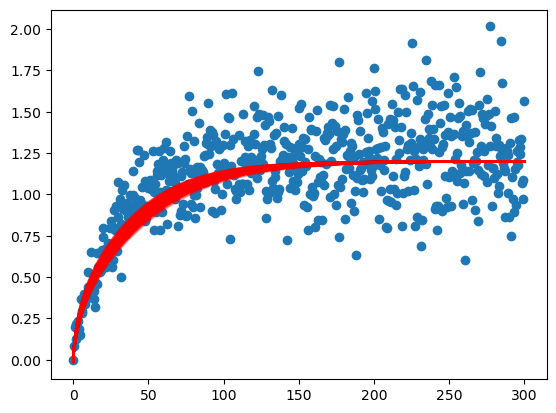

In [207]:
#data_folder_spectral = r'C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_12_13_Bayes_Seongrok_Spectral'
#Raw_File = pd.read_csv(f'{data_folder_spectral}/PL_Ratios_glass.dat', sep="\t")
#x = Raw_File['Time1'].values
#y = Raw_File['Data_glass'].values

#Raw_File = pd.read_csv(f'{data_folder_spectral}/PL_Ratios_perov.dat', sep="\t")
#x = Raw_File['Time2'].values
#y = Raw_File['Data_perov'].values

ratio_plot = np.array(ratio_collect)
ratio_plot -= np.median(ratio_plot,axis=0)[0]
ratio_save = ratio_plot/np.median(ratio_plot,axis=0)[-1] * 1.2

plt.scatter(x,y)
plt.plot(x, ratio_save.T, alpha=0.25, c='red')
#ratio -= 1

#plt.plot(np.arange(200), ratio, c='red')
plt.show()

In [208]:
#ratio_collect = np.array(ratio_collect)

ratio_plot = np.array(ratio_collect)
ratio_plot -= np.median(ratio_plot,axis=0)[0]
ratio_save = ratio_plot/np.median(ratio_plot,axis=0)[-1] *1.2

ratio_median = np.median(ratio_save,axis=0)
ratio_q1 = np.quantile(ratio_save,0.25, axis=0)
ratio_q3 = np.quantile(ratio_save,0.75, axis=0)
df_ratio_save = pd.DataFrame()

df_ratio_save['time (ns)'] = x
df_ratio_save['ratio_median'] = ratio_median
df_ratio_save['ratio_q1'] = ratio_q1
df_ratio_save['ratio_q3'] = ratio_q3

df_ratio_save.to_csv(f'{data_folder_spectral}/prediction_from_BayesMCMC_glass.dat', sep='\t', index= True, mode='w')


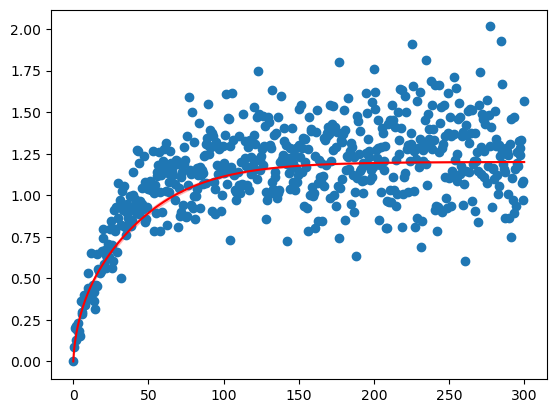

In [209]:
plt.scatter(x,y)
plt.plot(x, ratio_median, c='red')
plt.fill_between(x, ratio_q1, ratio_q3, color='red', alpha=0.2, zorder=-1000)
#ratio -= 1


In [241]:
print(x)

[  0.           0.49999999   0.99999997   1.4999999    1.99999994
   2.49999998   2.9999998    3.49999985   3.99999989   4.49999993
   4.99999997   5.50000001   5.99999961   6.49999965   6.99999969
   7.49999973   7.99999977   8.49999982   8.99999986   9.4999999
   9.99999994  10.49999998  11.00000002  11.50000006  11.99999922
  12.49999926  12.9999993   13.49999934  13.99999938  14.49999942
  14.99999946  15.49999951  15.99999955  16.49999959  16.99999963
  17.49999967  17.99999971  18.49999975  18.9999998   19.49999984
  19.99999988  20.49999992  20.99999996  21.5         22.00000004
  22.50000009  23.00000013  23.50000017  23.99999843  24.49999847
  24.99999852  25.49999856  25.9999986   26.49999864  26.99999868
  27.49999872  27.99999876  28.49999881  28.99999885  29.49999889
  29.99999893  30.50000075  30.99999901  31.50000083  31.99999909
  32.49999736  32.99999918  33.49999744  33.99999926  34.49999753
  34.99999934  35.49999761  35.99999943  36.49999769  36.99999951
  37.499997

In [28]:
import numpy as np
n_em = 1e18*np.exp(-0.01/(8.6e-5*300))

n_em_new = - np.log(n_em / 2e18)*8.6e-5*300
print(n_em_new)

0.027883197258446592


In [35]:
Nc = 2*(2*np.pi*0.2*9.1e-31*1.38e-23*300/6.262e-34**2)**(3/2) * 1e-6
print(Nc)

2.6531890852377426e+18
